<a href="https://colab.research.google.com/github/pedro-varela1/Arquivos_ELE-606/blob/main/Atividade_7_NN_ELE606.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação com Multi Layer Perceptron
## ELE606 - Tópicos Especiais em Inteligência Artificial

> Aluno: [Pedro Artur Varela](https://github.com/pedro-varela1)

<img src="https://th.bing.com/th/id/OIP.5k_F1J9j6Z3XRwl9G5JrdgHaI5?pid=ImgDet&rs=1"
    style="width:500px; float: right; margin: 0 40px 40px 40px;"></img>
  
![divider](https://webstockreview.net/images/divider-clipart-design-line-5.png)



## Introdução

Multi Layer Perceptron (MLP) é um tipo de rede neural artificial composta por múltiplas camadas, incluindo uma camada de entrada, uma ou mais camadas ocultas e uma camada de saída. Cada neurônio em uma camada está conectado a todos os neurônios na camada seguinte por meio de pesos ajustáveis. O MLP é capaz de aprender relações complexas e não lineares nos dados e é frequentemente usado em tarefas de classificação e regressão. Neural Networks, ou Redes Neurais, são modelos computacionais inspirados no sistema nervoso central dos animais. Eles são compostos por unidades interconectadas, ou neurônios artificiais, que processam informações, simulando a capacidade do cérebro de processar paralelamente grandes quantidades de dados. As redes neurais têm sido amplamente aplicadas em diversas áreas, incluindo reconhecimento de padrões, processamento de linguagem natural e visão computacional, devido à sua capacidade de aprender representações complexas e extrair características relevantes dos dados.

---

## Algoritmo e código

### Pré-processamento dos dados

Primeiramente, vamos importar os módulos utilizados.

In [1]:
import pandas as pd   # Manipulação dos dados
import numpy as np    # Análises numéricas
import matplotlib.pyplot as plt   # Geração de gráficos
plt.style.use('ggplot')

from sklearn.datasets import load_iris    # Carregar dataset
from sklearn.preprocessing import StandardScaler  # Normalização
from sklearn.model_selection import train_test_split    # Seperar dados para treino e teste

Vamos carregar a base de dados na configuração desejada, normalizar os dados para ficar com média 0 e variância 1 e já aplicar a separação de dados de treinamento e dados de teste.

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Normalizacao
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split em teste e treinamento
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

É sempre importante realizarmos algumas análise na estrutura de dados que nós temos. Por isso, vamos visualizar a separação dos rótulos com base nas duas primeiras features.

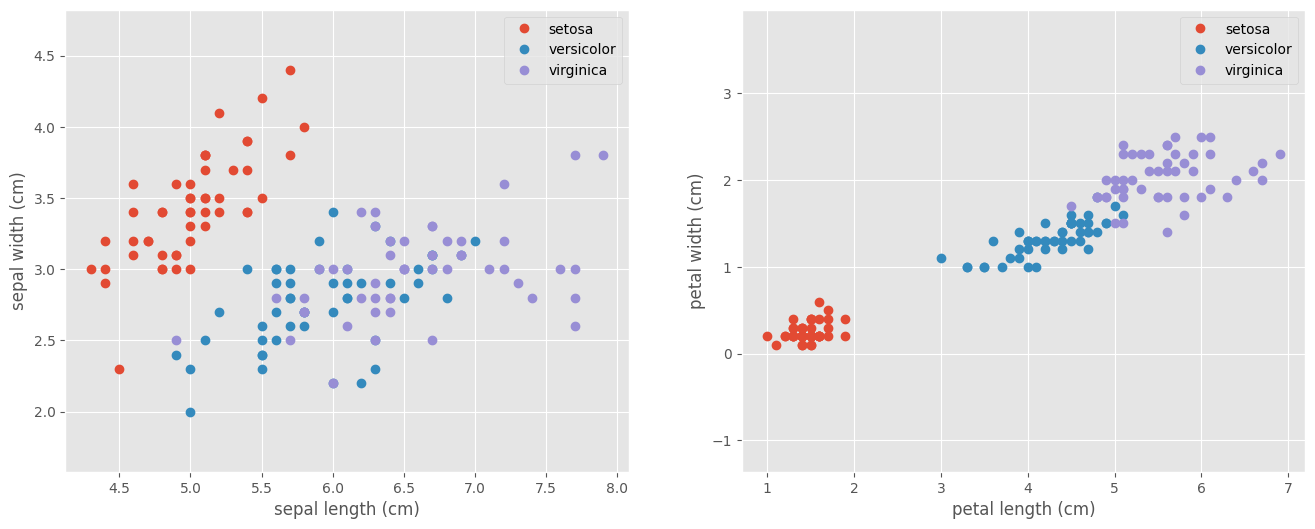

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1],
             linestyle='none',
             marker='o',
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3],
             linestyle='none',
             marker='o',
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

### Treinamento do Modelo

Vamos configurar o modelo de rede neural utilizando a biblioteca pytorch. O modelo terá 2 camadas escondidas, ambas com 16 neurônios.

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [5]:
model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=3, bias=True)
)

Vemos as características do modelo corretamente.

Para acompanhar o progresso de forma mais eficiente, podemos usar o tqdm, que é uma barra de progresso ótima e fácil de usar para nossas épocas de treinamento.

In [6]:
import tqdm

EPOCHS  = 100   # Quantidades de vezes que o modelo irá percorrer os dados de treinamento
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()

    # Nenhum gradiente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 569.14it/s]


O modelo está treinado.

### Análise dos Resultados

Vamos olhar a acurácia e o validation loss do modelo em função das épocas de treinamento.

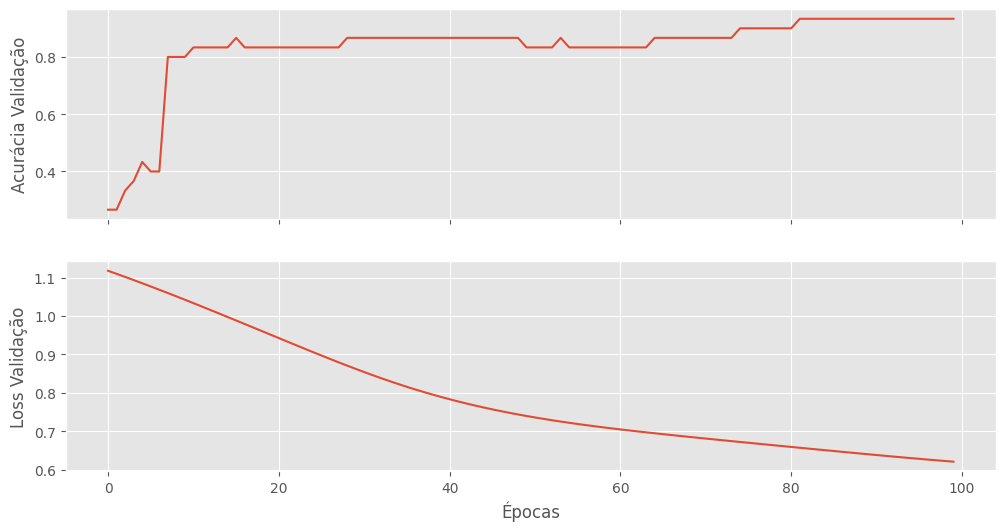

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("Acurácia Validação")
ax2.plot(loss_list)
ax2.set_ylabel("Loss Validação")
ax2.set_xlabel("Épocas");

In [8]:
accuracy_list[-1]

0.9333333373069763

Atingimos 93.33% de acurácia nos dados de validação.